###  Модель поширення горіння лісу

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

In [2]:
# Визначення станів
EMPTY = 0         # Випалена земля
GRASS = 1         # Трава
SPARSE_FOREST = 2 # Рідкісний ліс
DENSE_FOREST = 3  # Густий ліс
FIRE = 4          # Вогонь

# Параметри
SPARSE_PROB = 0.3  # Ймовірність поширення пожежі у рідкому лісі
DENSE_PROB = 0.7   # Ймовірність поширення пожежі у густому лісі

In [3]:
# Ініціалізація поля і лічильника часу
size = 50
field = np.random.choice([EMPTY, GRASS, SPARSE_FOREST, DENSE_FOREST], size=(size, size), p=[0.1, 0.2, 0.3, 0.4])
time_since_change = np.zeros((size, size), dtype=int)

# Початкова клітинка з вогнем в центрі
field[size // 2, size // 2] = FIRE
time_since_change[size // 2, size // 2] = 0

# Визначення кольорової карти для візуалізації
colors = ['black', 'lightgreen', 'forestgreen', 'darkgreen', 'red']
cmap = ListedColormap(colors)

# Збереження статистики для графіка
empty_counts = []
grass_counts = []
sparse_forest_counts = []
dense_forest_counts = []
fire_counts = []

In [4]:
# Функція для оновлення поля
def update_field(field, time_since_change):
    new_field = field.copy()
    new_time = time_since_change.copy()
    
    for i in range(1, size - 1):
        for j in range(1, size - 1):
            s, t = field[i, j], time_since_change[i, j]
            
            # Якщо клітинка горить
            if s == FIRE:
                if t < 2:
                    new_time[i, j] += 1
                else:
                    new_field[i, j] = EMPTY
                    new_time[i, j] = 1
            
                # Поширення пожежі на сусідів
                for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
                    if new_field[ni, nj] in [GRASS, SPARSE_FOREST, DENSE_FOREST]:
                        prob = {GRASS: 0.1, SPARSE_FOREST: SPARSE_PROB, DENSE_FOREST: DENSE_PROB}[new_field[ni, nj]]
                        if np.random.rand() < prob:
                            new_field[ni, nj] = FIRE
                            new_time[ni, nj] = 0
                    
            # Фіксуємо стан випаленої землі
            elif s == EMPTY:
                new_field[i, j] = EMPTY
                new_time[i, j] = t
            
            # Трава -> рідкісний ліс 
            elif s == GRASS and t >= random.randint(20, 50):
                new_field[i, j] = SPARSE_FOREST
                new_time[i, j] = 10
            
            # Рідкісний ліс -> густий ліс через 49 кроків
            elif s == SPARSE_FOREST and t == 49:
                new_field[i, j] = DENSE_FOREST
                new_time[i, j] = 50
            
            else:
                new_time[i, j] += 1
    
    return new_field, new_time

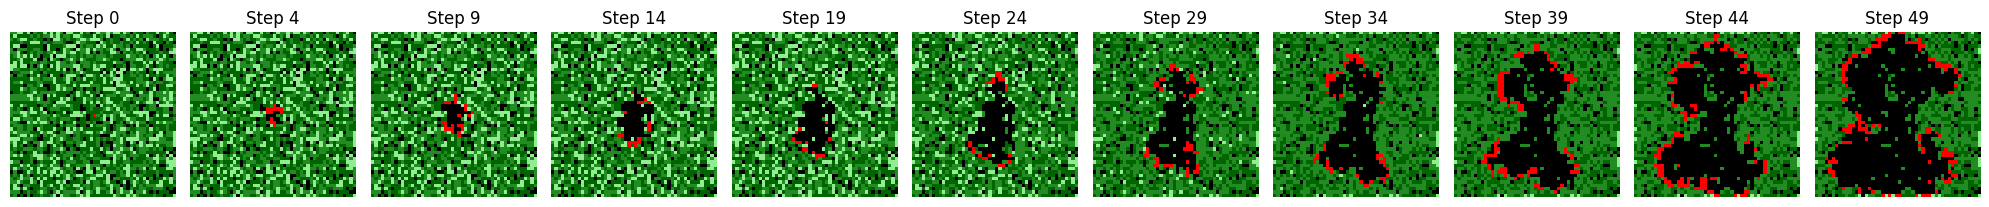

In [5]:
# Визначення кроків для візуалізації
steps_to_display = [0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49]  
fig, axes = plt.subplots(1, len(steps_to_display), figsize=(20, 4))

# Моделювання процесу та збір статистики
for step in range(max(steps_to_display) + 1):
    # Збираємо статистику
    empty_counts.append(np.sum(field == EMPTY))
    grass_counts.append(np.sum(field == GRASS))
    sparse_forest_counts.append(np.sum(field == SPARSE_FOREST))
    dense_forest_counts.append(np.sum(field == DENSE_FOREST))
    fire_counts.append(np.sum(field == FIRE))
    
    # Візуалізуємо поле на певних кроках
    if step in steps_to_display:
        ax = axes[steps_to_display.index(step)]
        ax.imshow(field, cmap=cmap, vmin=0, vmax=4)
        ax.set_title(f'Step {step}')
        ax.axis('off')  # Вимкнути осі
    
    # Оновлення поля для наступного кроку
    field, time_since_change = update_field(field, time_since_change)

plt.tight_layout()
plt.show()

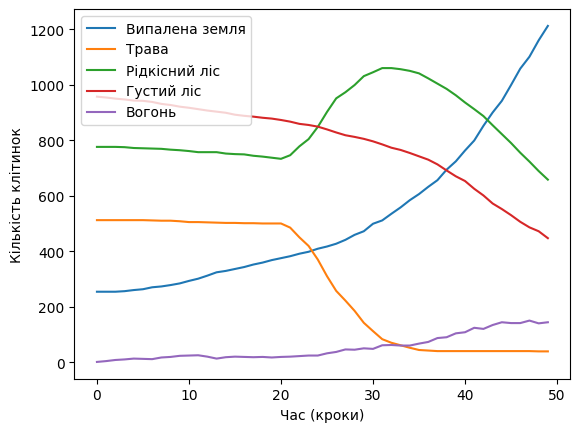

In [6]:
# Побудова графіків для кожного стану
plt.plot(empty_counts, label="Випалена земля")
plt.plot(grass_counts, label="Трава")
plt.plot(sparse_forest_counts, label="Рідкісний ліс")
plt.plot(dense_forest_counts, label="Густий ліс")
plt.plot(fire_counts, label="Вогонь")
plt.xlabel("Час (кроки)")
plt.ylabel("Кількість клітинок")
plt.legend()
plt.show()

### Модель вірусної епідемія

In [7]:
# Визначення станів
HEALTHY = 0    # Здоровий без хворих сусідів
INFECTED = 1   # Хворий, що заразився
RECOVERING = 2 # Хворіє, рахунок до одужання
IMMUNE = -1    # Імунний, відлік до втрати імунітету

# Параметри
INFECTION_PROB = 0.4  # Ймовірність зараження
RECOVERY_TIME = 10     # Час хвороби до одужання
IMMUNITY_TIME = 5     # Час тривання імунітету
LOSS_IMMUNITY_PROB = 0.5 # Ймовірність втрати імунітету

# Розміри поля
size = 25
time_steps = 50

In [8]:
# Початкове поле: всі здорові, крім центральної клітинки
field = np.zeros((size, size), dtype=int)
field[size // 2, size // 2] = INFECTED  # Центральна клітинка заражена

# Визначення кольорової карти для станів
colors = ['lightgreen', 'red', 'blue', 'gray']  # Здоровий - зелений, Заражений - червоний, Імунний - синій
cmap = ListedColormap(colors)

In [9]:
# Функція для оновлення поля
def update_field(field):
    new_field = field.copy()
    for i in range(size):
        for j in range(size):
            s = field[i, j]

            if s == HEALTHY:
                # Перевірка всіх 8 сусідів на наявність заражених
                neighbors = [
                    field[(i-1) % size, j], field[(i+1) % size, j],   # Верхній і нижній сусіди
                    field[i, (j-1) % size], field[i, (j+1) % size],   # Лівий і правий сусіди
                    field[(i-1) % size, (j-1) % size], field[(i-1) % size, (j+1) % size],  # Верхні діагоналі
                    field[(i+1) % size, (j-1) % size], field[(i+1) % size, (j+1) % size]   # Нижні діагоналі
                ]
                # Якщо є хворі сусіди, з ймовірністю зараження клітинка заражається
                if INFECTED in neighbors and np.random.rand() < INFECTION_PROB:
                    new_field[i, j] = INFECTED

            elif s == INFECTED:
                # Початок хвороби, переводимо клітинку у стан хворого (збільшуємо тривалість хвороби)
                new_field[i, j] = RECOVERING

            elif RECOVERING <= s < RECOVERING + RECOVERY_TIME - 1:
                # Клітинка продовжує хворіти
                new_field[i, j] += 1

            elif s == RECOVERING + RECOVERY_TIME - 1:
                # Одужання після повної тривалості хвороби, отримує імунітет
                new_field[i, j] = IMMUNE

            elif IMMUNE <= s < IMMUNE + IMMUNITY_TIME:
                # Імунітет поступово слабшає з ймовірністю втрати імунітету
                if np.random.rand() < LOSS_IMMUNITY_PROB:
                    new_field[i, j] += 1
                    # Якщо імунітет закінчується, клітинка стає здоровою
                    if new_field[i, j] == HEALTHY:
                        new_field[i, j] = HEALTHY

    return new_field

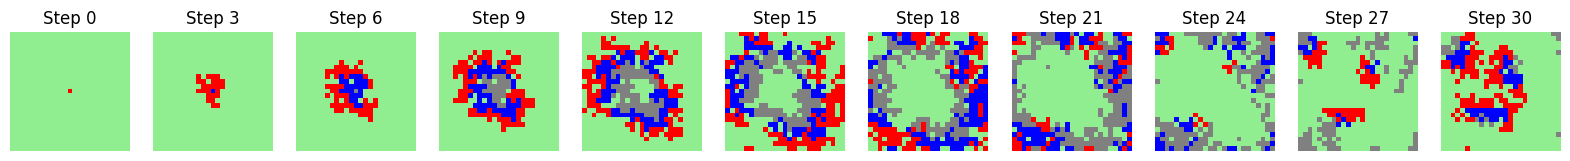

In [10]:
# Зберігаємо статистику для аналізу
percent_healthy = []
percent_infected = []
percent_immune = []

# Визначення кроків для візуалізації
steps_to_display = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]

# Моделювання процесу та візуалізація
fig, axes = plt.subplots(1, len(steps_to_display), figsize=(20, 3))

for step in range(time_steps):
    # Розрахунок статистики
    healthy_count = np.sum(field == HEALTHY)
    infected_count = np.sum((field >= 1) & (field < RECOVERY_TIME))  # Усі етапи зараження
    immune_count = np.sum(field < 0)

    percent_healthy.append(healthy_count / (size * size) * 100)
    percent_infected.append(infected_count / (size * size) * 100)
    percent_immune.append(immune_count / (size * size) * 100)

    # Оновлення поля
    field = update_field(field)

    # Візуалізація на певних кроках
    if step in steps_to_display:
        ax = axes[steps_to_display.index(step)]
        ax.imshow(field, cmap=cmap, vmin=-1, vmax=RECOVERY_TIME)
        ax.set_title(f'Step {step}')
        ax.axis('off')

plt.show()

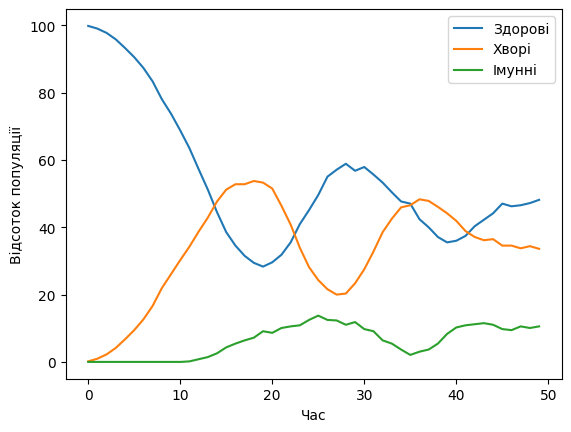

In [11]:
# Графік для показу еволюції
plt.plot(percent_healthy, label="Здорові")
plt.plot(percent_infected, label="Хворі")
plt.plot(percent_immune, label="Імунні")
plt.xlabel("Час")
plt.ylabel("Відсоток популяції")
plt.legend()
plt.show()

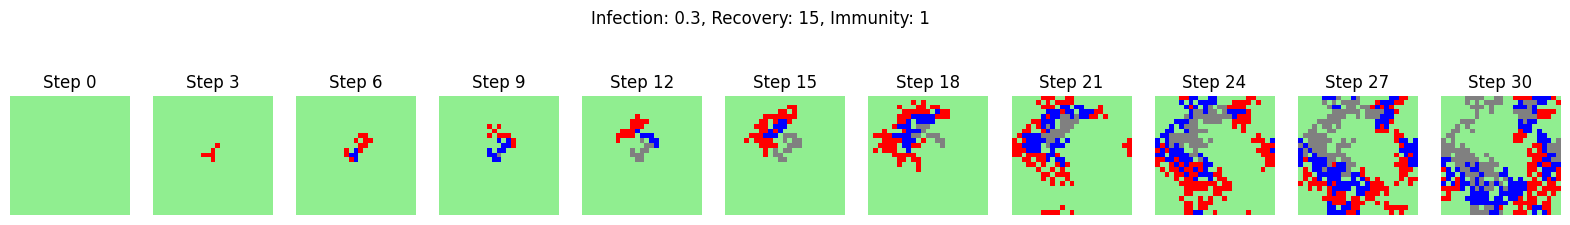

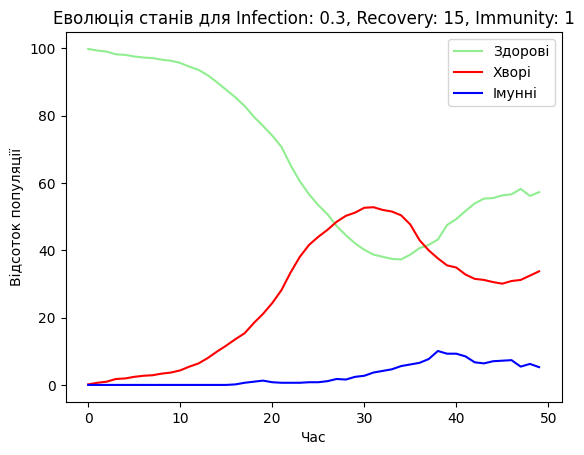

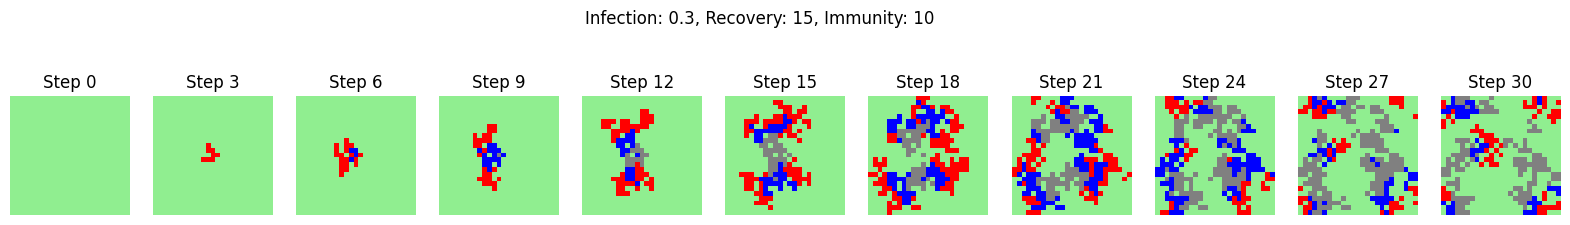

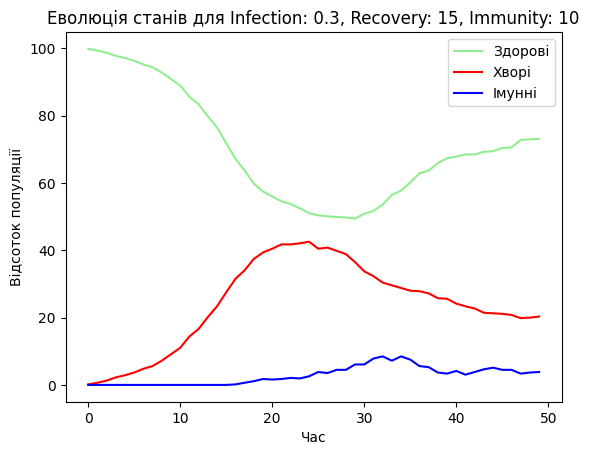

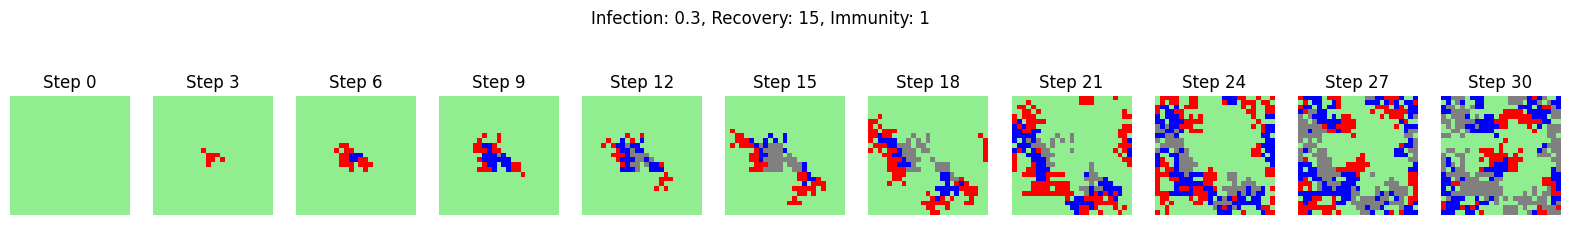

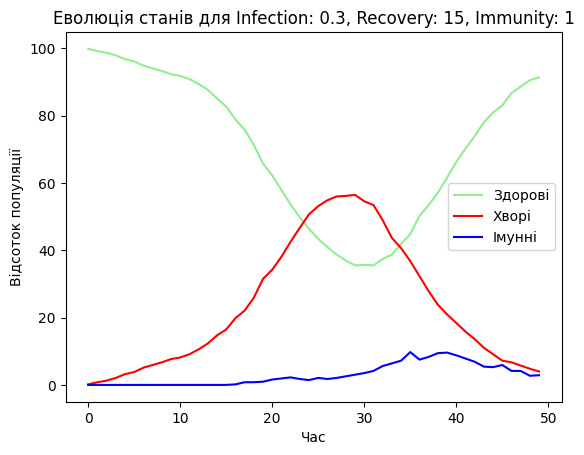

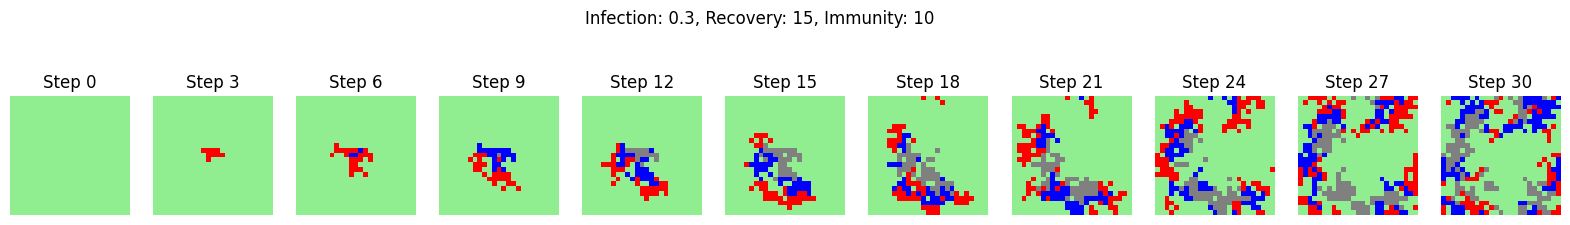

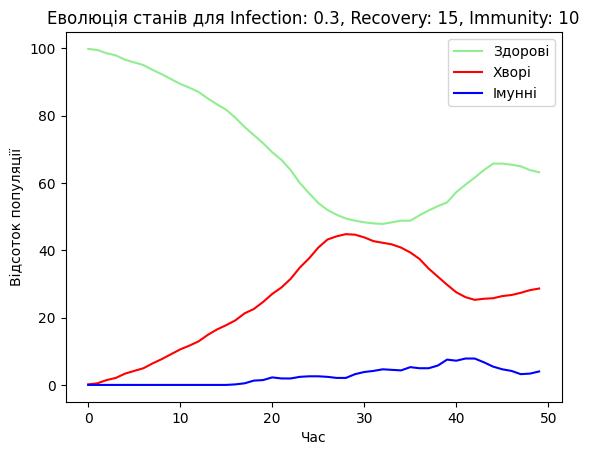

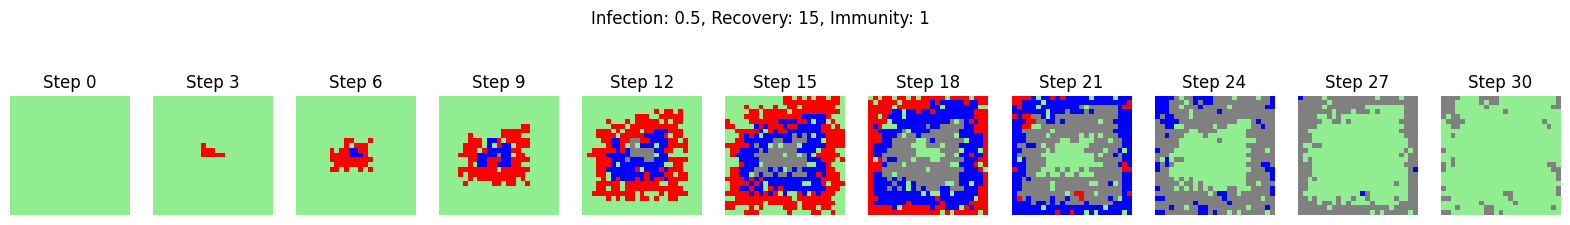

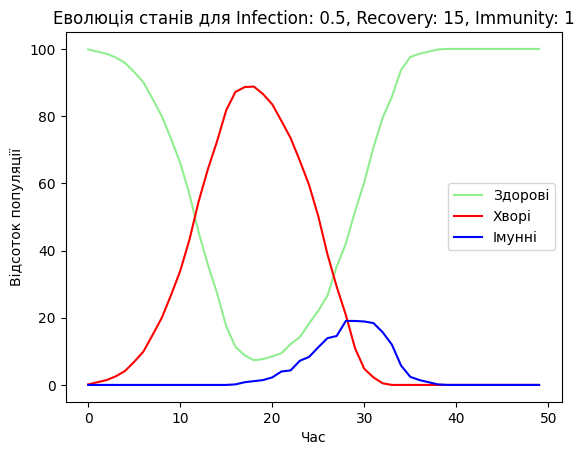

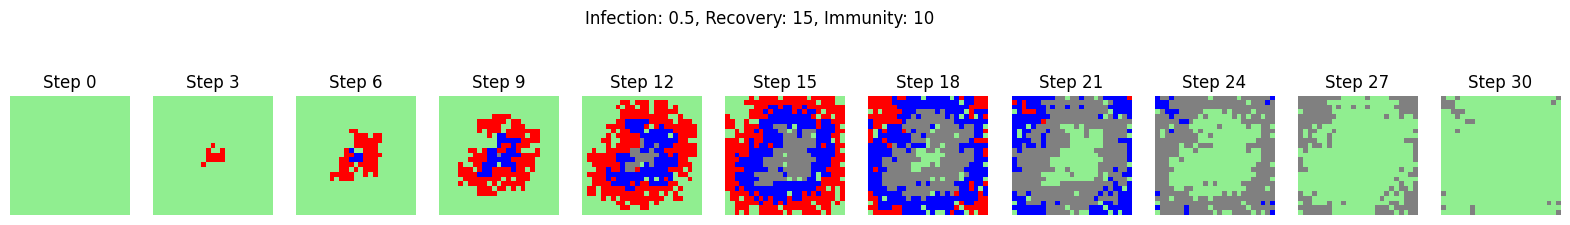

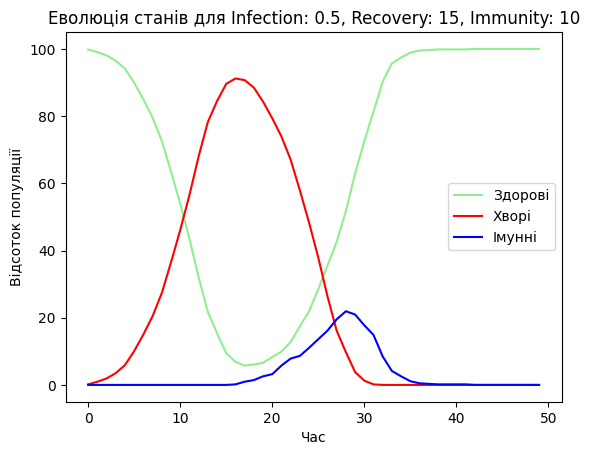

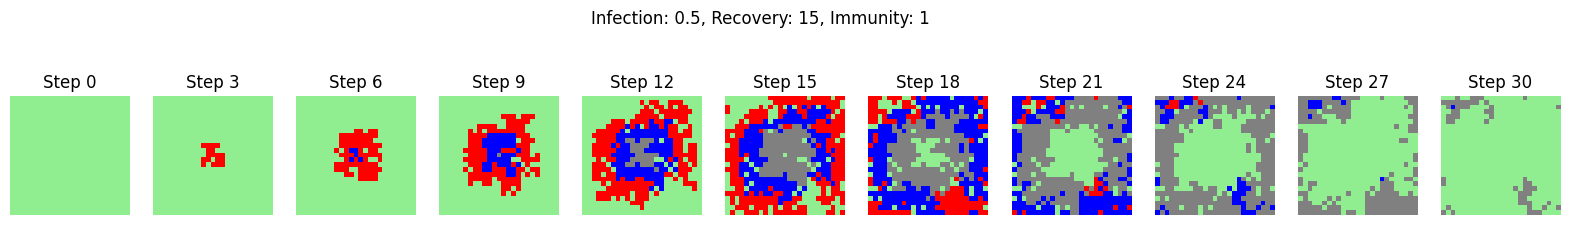

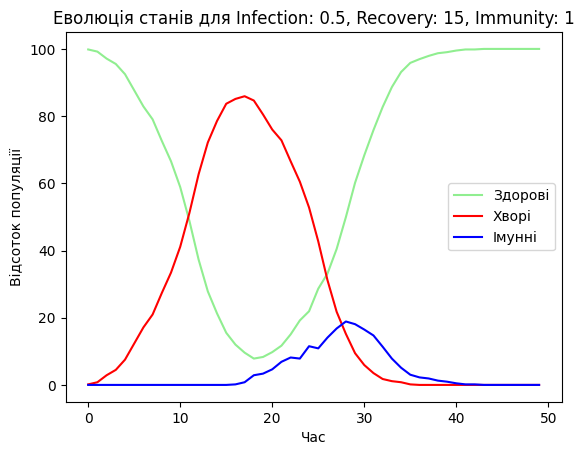

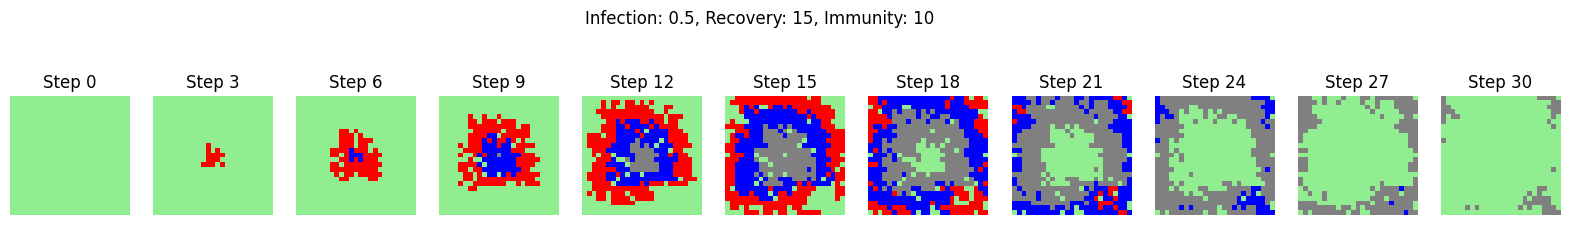

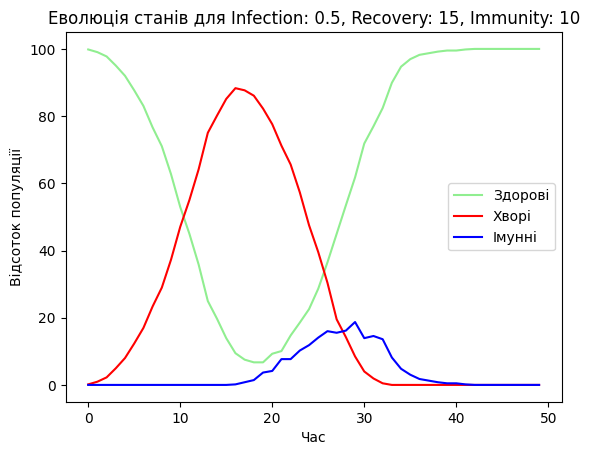

In [12]:
# Список значень для параметрів, які хочемо дослідити
infection_probs = [0.3, 0.5]
recovery_times = [15, 15]
immunity_times = [1, 10]

# Ініціалізація поля для кожного набору параметрів
for INFECTION_PROB in infection_probs:
    for RECOVERY_TIME in recovery_times:
        for IMMUNITY_TIME in immunity_times:
            # Перезапускаємо поле для кожного запуску
            field = np.zeros((size, size), dtype=int)
            field[size // 2, size // 2] = INFECTED  # Центральна клітинка заражена
            
            # Очищення попередніх даних для відсотків
            percent_healthy, percent_infected, percent_immune = [], [], []
            
            fig, axes = plt.subplots(1, len(steps_to_display), figsize=(20, 3))
            fig.suptitle(f'Infection: {INFECTION_PROB}, Recovery: {RECOVERY_TIME}, Immunity: {IMMUNITY_TIME}')
            
            for step in range(time_steps):
                # Збираємо статистику
                healthy_count = np.sum(field == HEALTHY)
                infected_count = np.sum((field >= 1) & (field < RECOVERY_TIME))  # Усі етапи зараження
                immune_count = np.sum(field < 0)

                percent_healthy.append(healthy_count / (size * size) * 100)
                percent_infected.append(infected_count / (size * size) * 100)
                percent_immune.append(immune_count / (size * size) * 100)

                # Оновлюємо поле
                field = update_field(field)

                # Візуалізуємо обрані кроки
                if step in steps_to_display:
                    ax = axes[steps_to_display.index(step)]
                    ax.imshow(field, cmap=cmap, vmin=-1, vmax=RECOVERY_TIME)
                    ax.set_title(f'Step {step}')
                    ax.axis('off')
            
            # Відображення еволюції відсотків здорових, хворих та імунних
            plt.figure()
            plt.plot(percent_healthy, label="Здорові", color="lightgreen")
            plt.plot(percent_infected, label="Хворі", color="red")
            plt.plot(percent_immune, label="Імунні", color="blue")
            plt.xlabel("Час")
            plt.ylabel("Відсоток популяції")
            plt.legend()
            plt.title(f"Еволюція станів для Infection: {INFECTION_PROB}, Recovery: {RECOVERY_TIME}, Immunity: {IMMUNITY_TIME}")
            plt.show()
